In [1]:
import scipy
import scipy.io
from scipy import signal
import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import math
import pyedflib
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import LogNorm

matplotlib.rcParams['figure.figsize'] = (20, 10)

%run DetectSpike_SEEG.py
%run utils.py

In [2]:
# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientBeSa/BeSA/sub-01/Electrodes.xlsx', header=None)
valid_channels = ['EEG ' + name for name in df[0].tolist()]

In [ ]:
patient_ID = '1'

In [3]:
features = np.concatenate((np.load('full_run/features_720_1220.npy'),
                           np.load('full_run/features_1220_1720.npy'), 
                           np.load('full_run/features_1720_2100.npy')))

spike_ids = np.concatenate((np.load('full_run/spike_ids_720_1220.npy'),
                            np.load('full_run/spike_ids_1220_1720.npy'), 
                            np.load('full_run/spike_ids_1720_2100.npy')))

chan_ids = np.concatenate((np.load('full_run/chan_ids_720_1220.npy'),
                           np.load('full_run/chan_ids_1220_1720.npy'), 
                           np.load('full_run/chan_ids_1720_2100.npy')))

In [4]:
spike_ids = spike_ids - 60 * 2048 * 720

In [5]:
# Difference in time between IEDs
diffs = []
for channel in np.unique(chan_ids):
    diffs.extend(np.diff(spike_ids[chan_ids == channel]))

diffs = np.array(diffs)

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / freq < 30]

# Plot using histogram
g = sns.displot(filtered_diffs / freq, bins=30)

g.fig.set_size_inches(10, 5)
g.set(xlim=(0, 30))
g.ax.set_yscale('log')
g.fig.suptitle('Distribution of inter-IED intervals for BeSa')
plt.xlabel('Time (s)')

NameError: name 'freq' is not defined

In [7]:
%run utils.py
freq = 2048

In [8]:
all_seq_spikes, all_seq_chans = spikes_to_sequences(spike_ids, chan_ids, freq)

In [9]:
np.diff([all_seq_spike[0] / 2048 for all_seq_spike in all_seq_spikes]).min()

0.0205078125

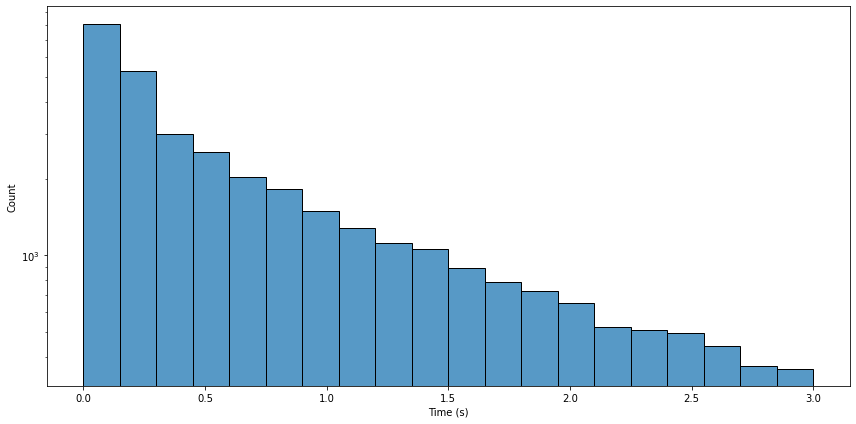

In [10]:
matplotlib.rcParams['figure.figsize'] = (12, 6)

# Difference in time between IEDs
diffs = np.diff(np.array([spikes[0] for spikes in all_seq_spikes]))# if len(spikes) > 1]))

# Only keep intervals < 3s
filtered_diffs = diffs[diffs / freq < 3]

ax = sns.histplot(filtered_diffs / 2048, bins=20, binrange=[0, 3])
ax.set_yscale('log')
ax.set(xlabel='Time (s)')

plt.tight_layout()
plt.savefig('inter_ied_intervals_BeSa.pdf')

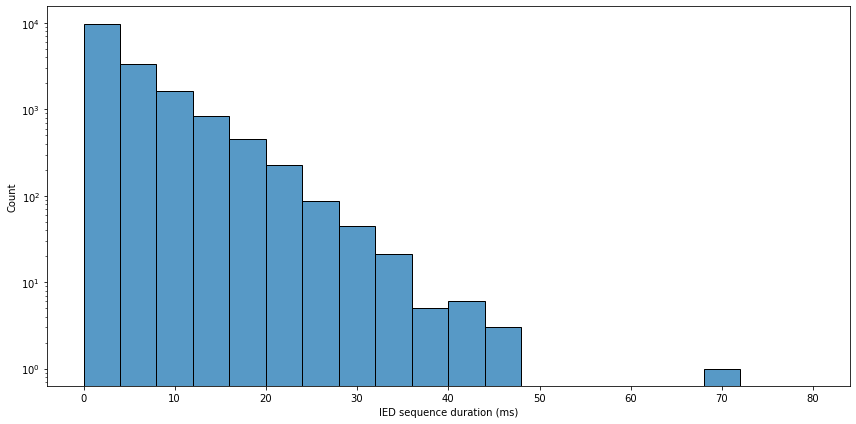

In [11]:
matplotlib.rcParams['figure.figsize'] = (12, 6)

# Work out lengths for each sequence and convert to ms
length_list = [(1000/freq) * (spike[-1] - spike[0]) for spike in all_seq_spikes if len(spike) > 1]

ax = sns.histplot(length_list, bins=20, binrange=[0, 80])
ax.set_yscale('log')
ax.set(xlabel='IED sequence duration (ms)')
    
plt.tight_layout()
plt.savefig('ied_durations_BeSa.pdf')

/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


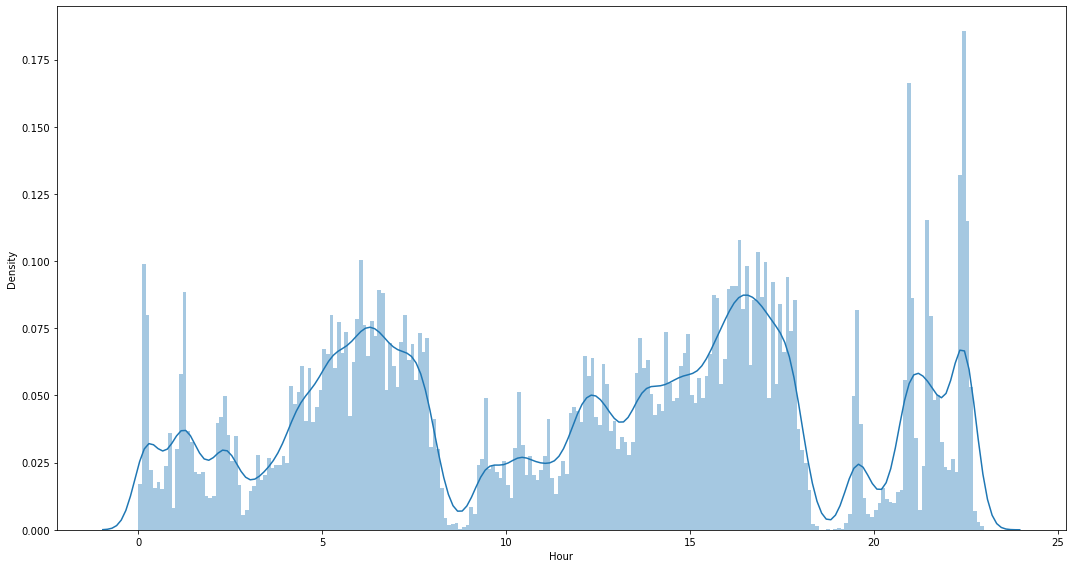

In [12]:
matplotlib.rcParams['figure.figsize'] = (15, 8)

sequence_starts = [spike[0] / (2048 * 60**2) for spike in all_seq_spikes]
ax = sns.distplot(sequence_starts, bins=230, kde_kws={"bw_method": 0.05})

ax.set(xlabel='Hour')

plt.tight_layout()
plt.savefig('ied_timeplot_BeSa.pdf')

In [13]:
%run utils.py

In [ ]:
sequence_transitions = matshow_cluster(valid_channels, all_seq_chans)
sequence_transitions.tight_layout()
sequence_transitions.savefig('sequence_transitions_BeSa.pdf')

In [14]:
all_seq_chans_chr = []

for all_seq_chan in all_seq_chans:
    seq = ''
    if len(all_seq_chan) > 1:
        for chan in all_seq_chan:
            seq += chr(int(chan))
        all_seq_chans_chr.append(seq)

In [16]:
import textdistance, Levenshtein, difflib

distance_matrix = np.zeros((len(all_seq_chans_chr), len(all_seq_chans_chr)))

for i, seq_1 in enumerate(tqdm(all_seq_chans_chr)):
    for j, seq_2 in enumerate(all_seq_chans_chr):
        if i < j:
            distance_matrix[i, j] = 1 - Levenshtein.ratio(seq_1, seq_2)

100%|████████████████████████████████████| 16543/16543 [01:11<00:00, 230.63it/s]


In [17]:
distance_matrix = distance_matrix + distance_matrix.T - np.diag(np.diag(distance_matrix))

In [19]:
from sklearn.cluster import DBSCAN

def cluster(eps=0.45):
    longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
    
    clustering = DBSCAN(eps=eps, min_samples=500, metric='precomputed').fit(distance_matrix)
    assigned_clusters = clustering.labels_
    
    cluster_counts = np.unique(assigned_clusters, return_counts=True)[1]

    print(cluster_counts)

    for cluster in range(-1, len(cluster_counts) - 1):
        matshow_cluster(valid_channels, longer, assigned_clusters, cluster).show()
        
    return assigned_clusters
    
# for eps in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
assigned_clusters = cluster(eps=0.35)

[7634 8909]


IndexError: index 106 is out of bounds for axis 0 with size 106

In [ ]:
from sklearn.cluster import DBSCAN
from functools import partial

def similarity(s, x, y):    
    return 1 - Levenshtein.ratio(s[int(x)], s[int(y)])

X = np.arange(len(all_seq_chans_chr)).reshape(-1, 1)

reduced_dataset = DBSCAN(eps=0.45, min_samples=500, metric=partial(similarity, all_seq_chans_chr)).fit(X)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.neighbors._ball_tree.BinaryTree._query_radius_single'
Traceback (most recent call last):
  File "sklearn/neighbors/_binary_tree.pxi", line 1236, in sklearn.neighbors._ball_tree.BinaryTree.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 322, in sklearn.neighbors._dist_metrics.DistanceMetric.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1130, in sklearn.neighbors._dist_metrics.PyFuncDistance.dist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1138, in sklearn.neighbors._dist_metrics.PyFuncDistance._dist
  File "/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_30259/855813981.py", line 4, in similarity
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.neighbors._ball_tree.BinaryTree._query_radius_single'
Traceback (most recent call last):
  File "sklearn/neighbors/_binary_tree.pxi", line 1236, in sklearn.neighbors._ball_tree.BinaryTree.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 322, in sklearn.neighbors._dist_metrics.DistanceMetric.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1130, in sklearn.neighbors._dist_metrics.PyFuncDistance.dist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1138, in sklearn.neighbors._dist_metrics.PyFuncDistance._dist
  File "/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_30259/855813981.py", line 4, in similarity
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.neighbors._ball_tree.BinaryTree._query_radius_single'
Traceback (most recent call last):
  File "sklearn/neighbors/_binary_tree.pxi", line 1236, in sklearn.neighbors._ball_tree.BinaryTree.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 322, in sklearn.neighbors._dist_metrics.DistanceMetric.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1130, in sklearn.neighbors._dist_metrics.PyFuncDistance.dist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1138, in sklearn.neighbors._dist_metrics.PyFuncDistance._dist
  File "/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_30259/855813981.py", line 3, in similarity
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.neighbors._ball_tree.BinaryTree._query_radius_single'
Traceback (most recent call last):
  File "sklearn/neighbors/_binary_tree.pxi", line 1236, in sklearn.neighbors._ball_tree.BinaryTree.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 322, in sklearn.neighbors._dist_metrics.DistanceMetric.rdist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1130, in sklearn.neighbors._dist_metrics.PyFuncDistance.dist
  File "sklearn/neighbors/_dist_metrics.pyx", line 1138, in sklearn.neighbors._dist_metrics.PyFuncDistance._dist
  File "/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_30259/855813981.py", line 4, in similarity
KeyboardInterrupt: 


In [15]:
np.unique(reduced_dataset.labels_, return_counts=True)[1]

array([12193, 10342,   864])

In [328]:
valid_channels

['EEG A1',
 'EEG A6',
 'EEG A7',
 'EEG A8',
 'EEG A9',
 'EEG A13',
 'EEG A14',
 'EEG A15',
 'EEG B1',
 'EEG B2',
 'EEG B3',
 'EEG B4',
 'EEG B5',
 'EEG B7',
 'EEG B8',
 'EEG B9',
 'EEG B10',
 'EEG B11',
 'EEG B12',
 'EEG C1',
 'EEG C2',
 'EEG C3',
 'EEG C4',
 'EEG C5',
 'EEG C8',
 'EEG C9',
 'EEG C10',
 'EEG C11',
 'EEG C12',
 'EEG D1',
 'EEG D2',
 'EEG D3',
 'EEG D4',
 'EEG D5',
 'EEG D6',
 'EEG D7',
 'EEG D8',
 'EEG D11',
 'EEG D12',
 'EEG D13',
 'EEG F1',
 'EEG F2',
 'EEG F3',
 'EEG F4',
 'EEG F5',
 'EEG F6',
 'EEG F9',
 'EEG F10',
 'EEG F11',
 'EEG F12',
 'EEG F13',
 'EEG G1',
 'EEG G2',
 'EEG G3',
 'EEG G4',
 'EEG G5',
 'EEG H1',
 'EEG H2',
 'EEG H3',
 'EEG H4',
 'EEG H6',
 'EEG H7',
 'EEG I1',
 'EEG I2',
 'EEG I3',
 'EEG I4',
 'EEG I8',
 'EEG J1',
 'EEG J2',
 'EEG J7',
 'EEG J8',
 'EEG K1',
 'EEG K2',
 'EEG K3',
 'EEG K4',
 'EEG K9',
 'EEG K10',
 'EEG L1',
 'EEG L2',
 'EEG L3',
 'EEG L4',
 'EEG L5',
 'EEG L6',
 'EEG L7',
 'EEG L11',
 'EEG L12',
 'EEG L13',
 'EEG L14',
 'EEG L15',

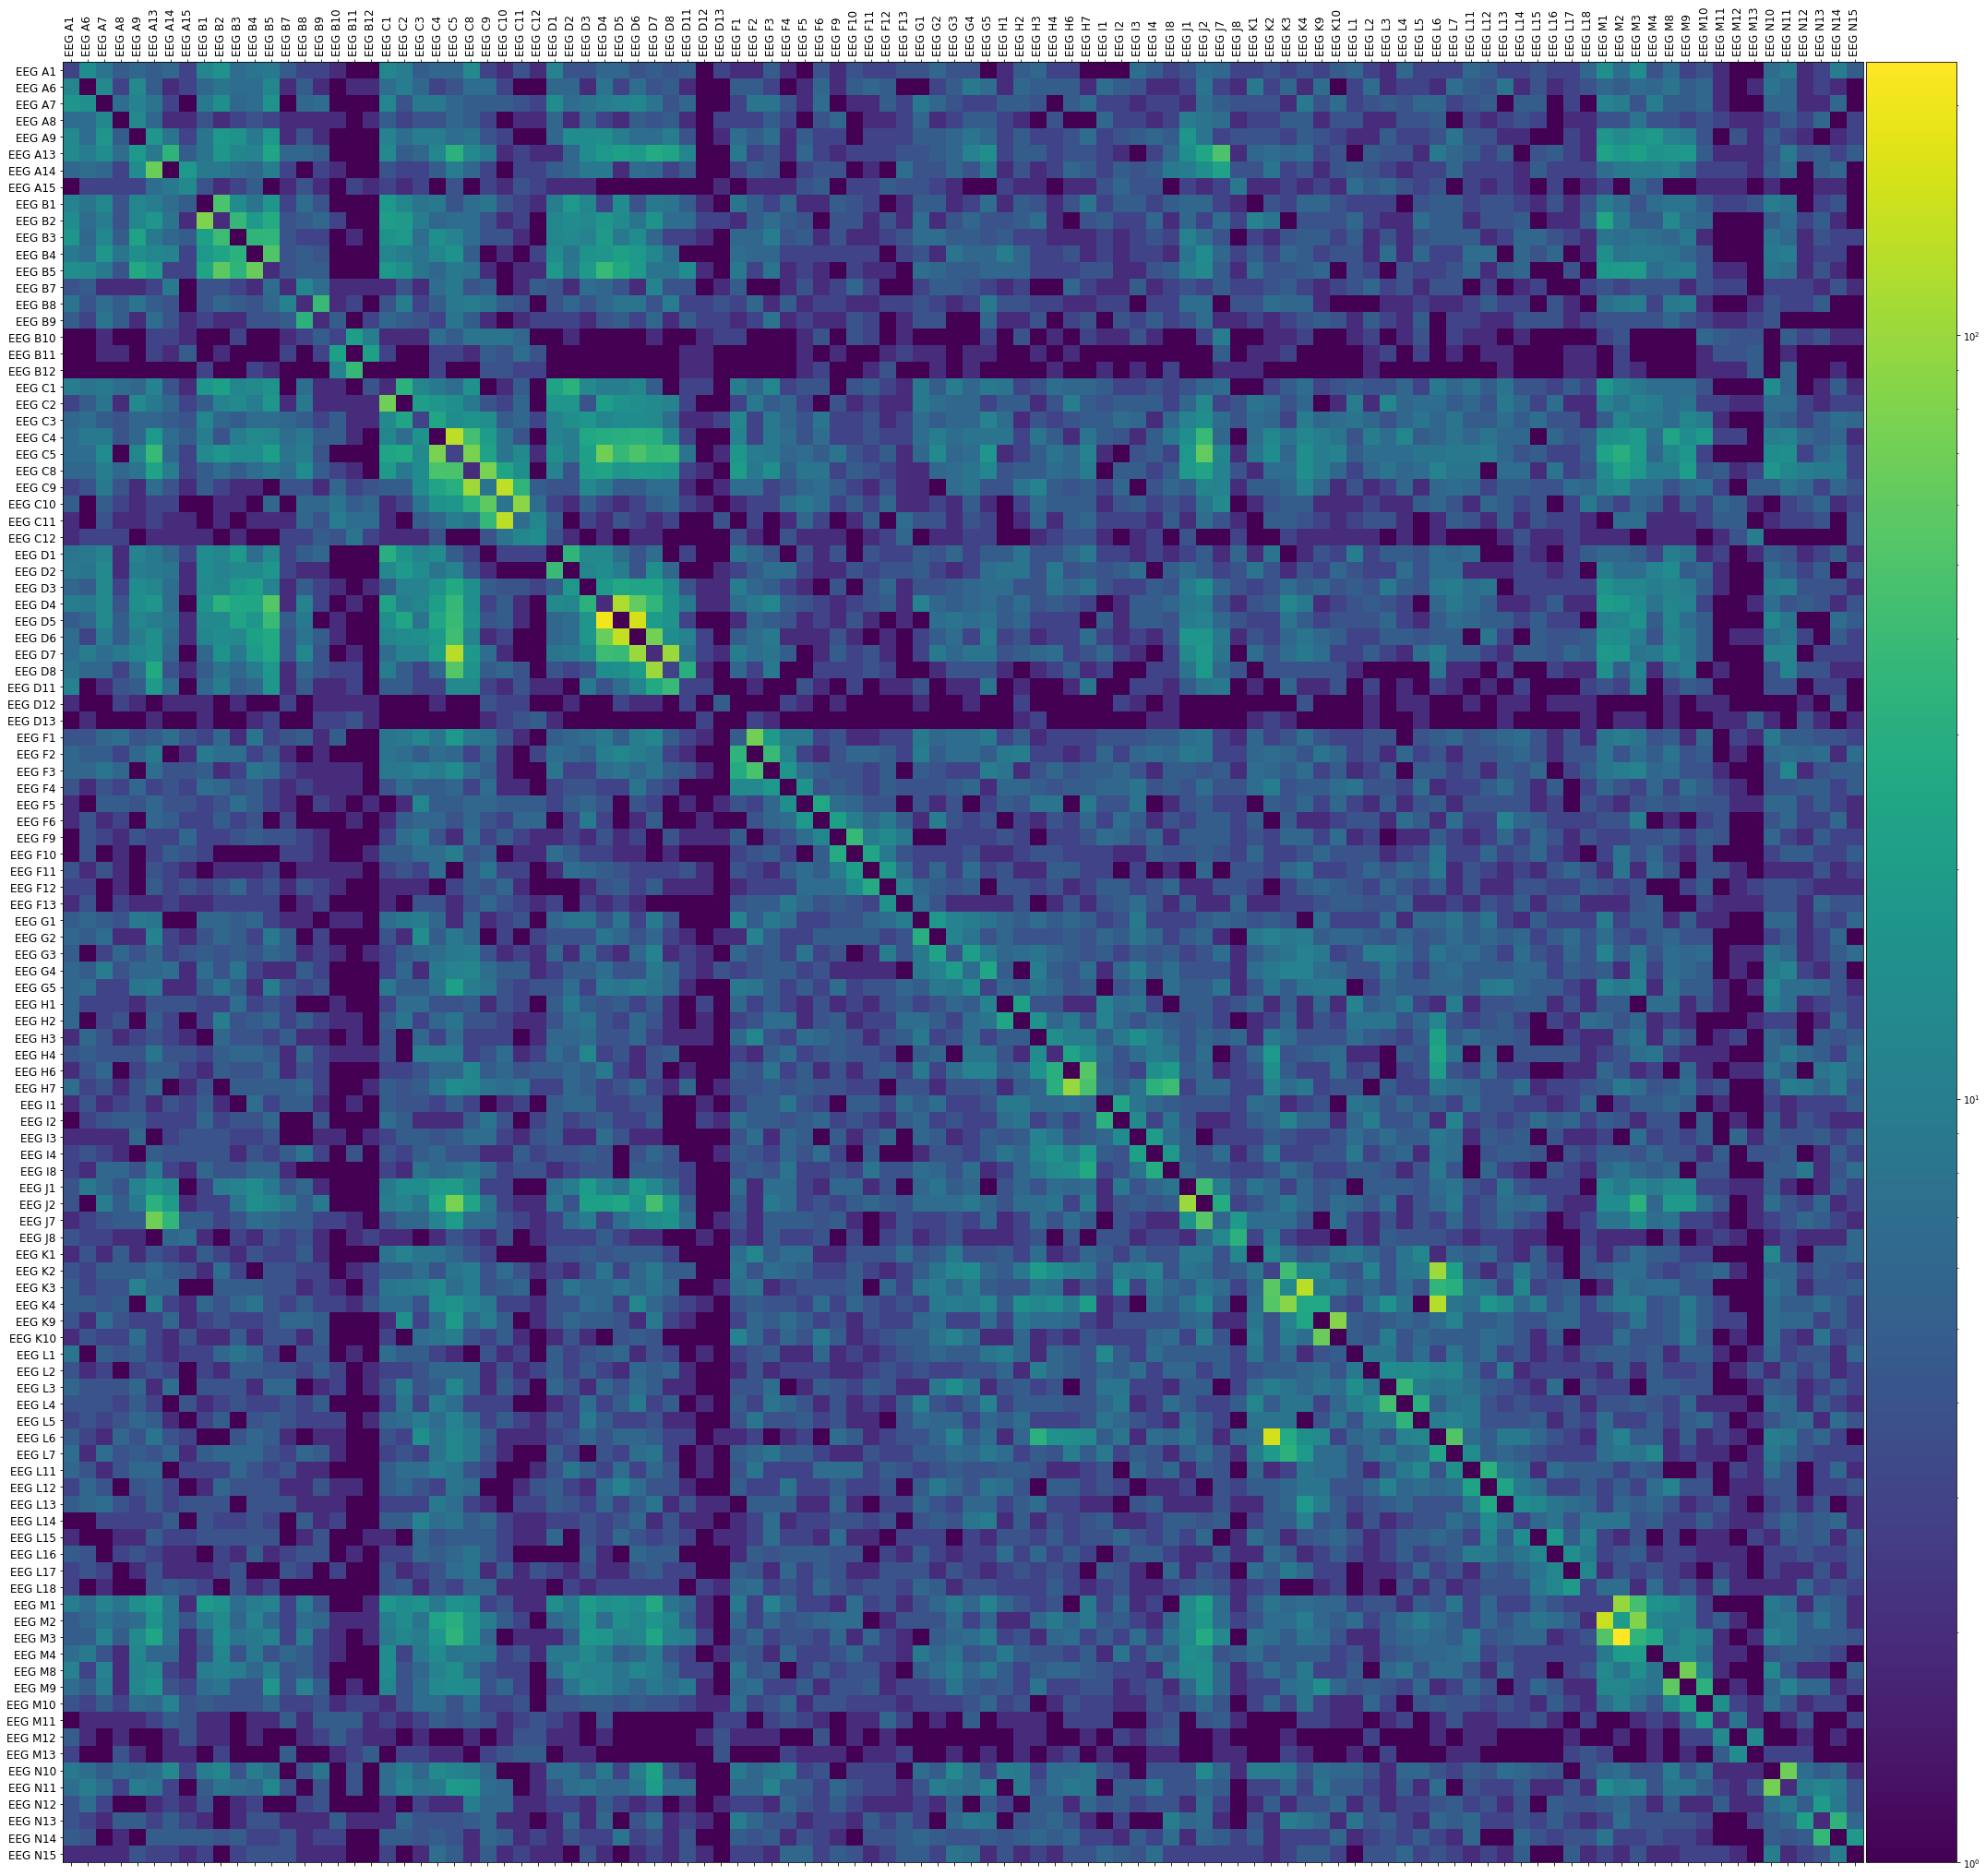

In [329]:
longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
sequence_transitions = matshow_cluster(valid_channels, longer, reduced_dataset.labels_, -1)
sequence_transitions.tight_layout()

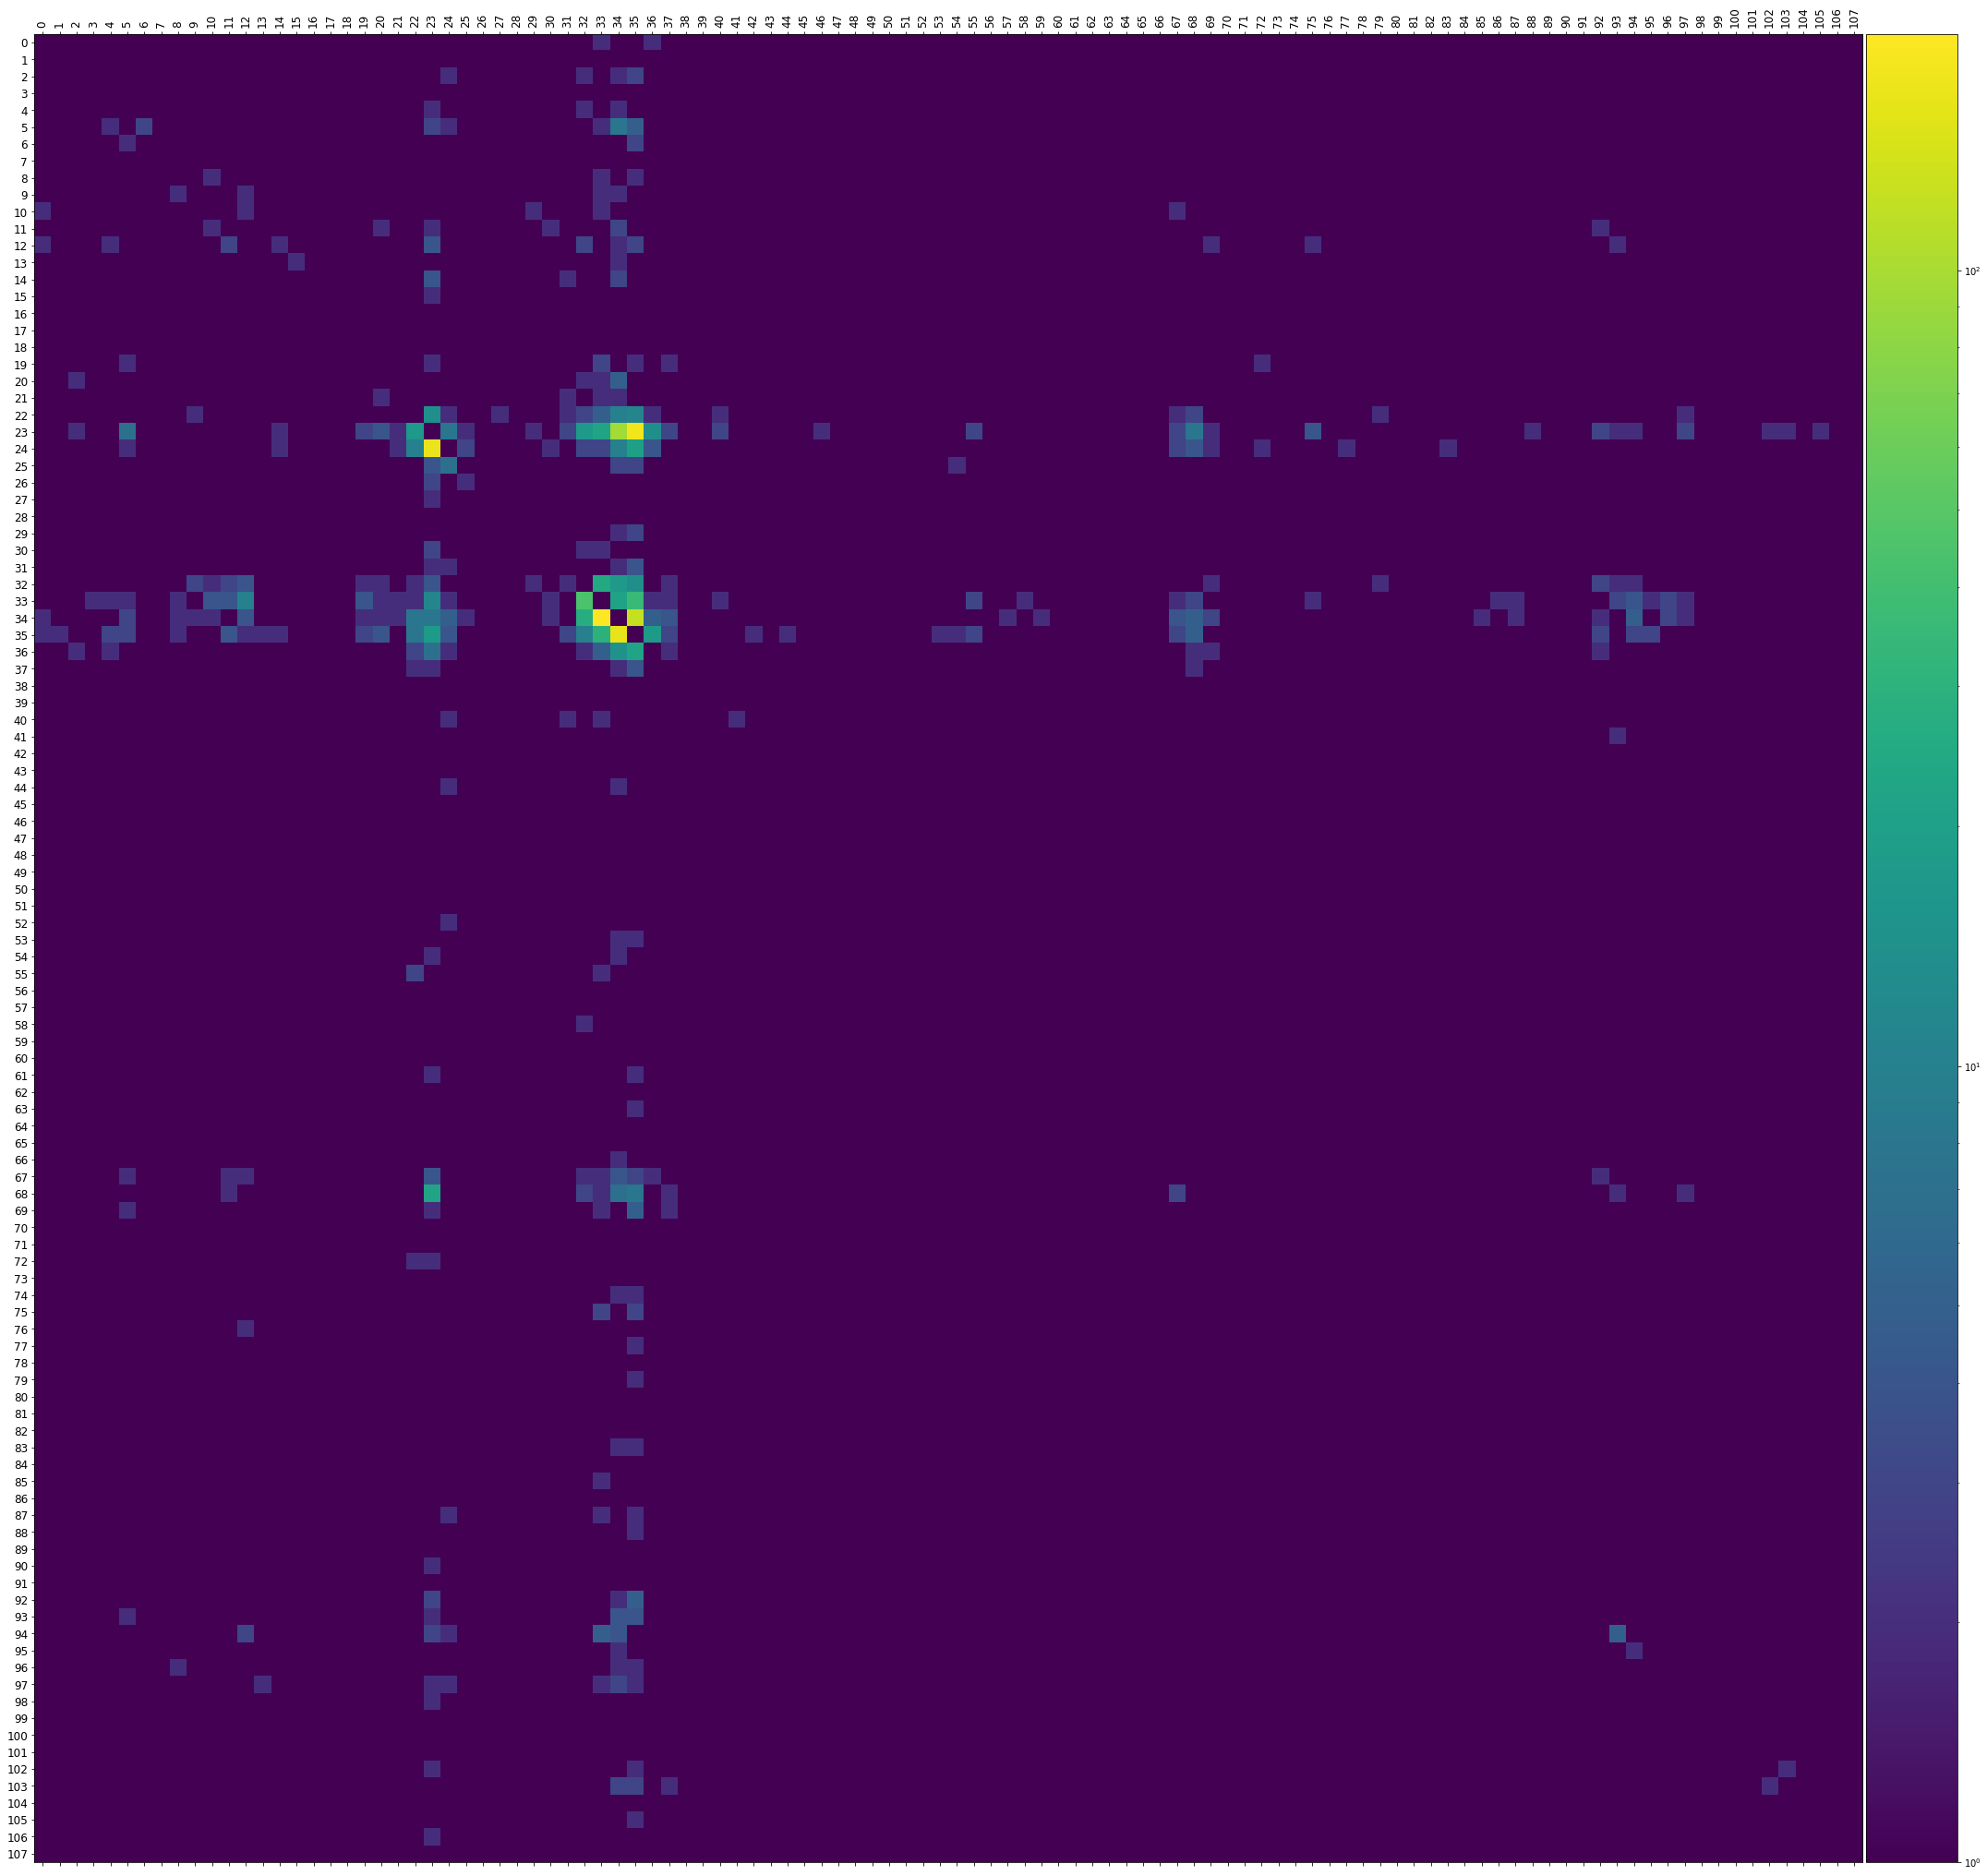

In [143]:
longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
sequence_transitions = matshow_cluster(range(108), longer, reduced_dataset.labels_, 1)
sequence_transitions.tight_layout()
sequence_transitions.savefig('cluster_1_BeSa.pdf')

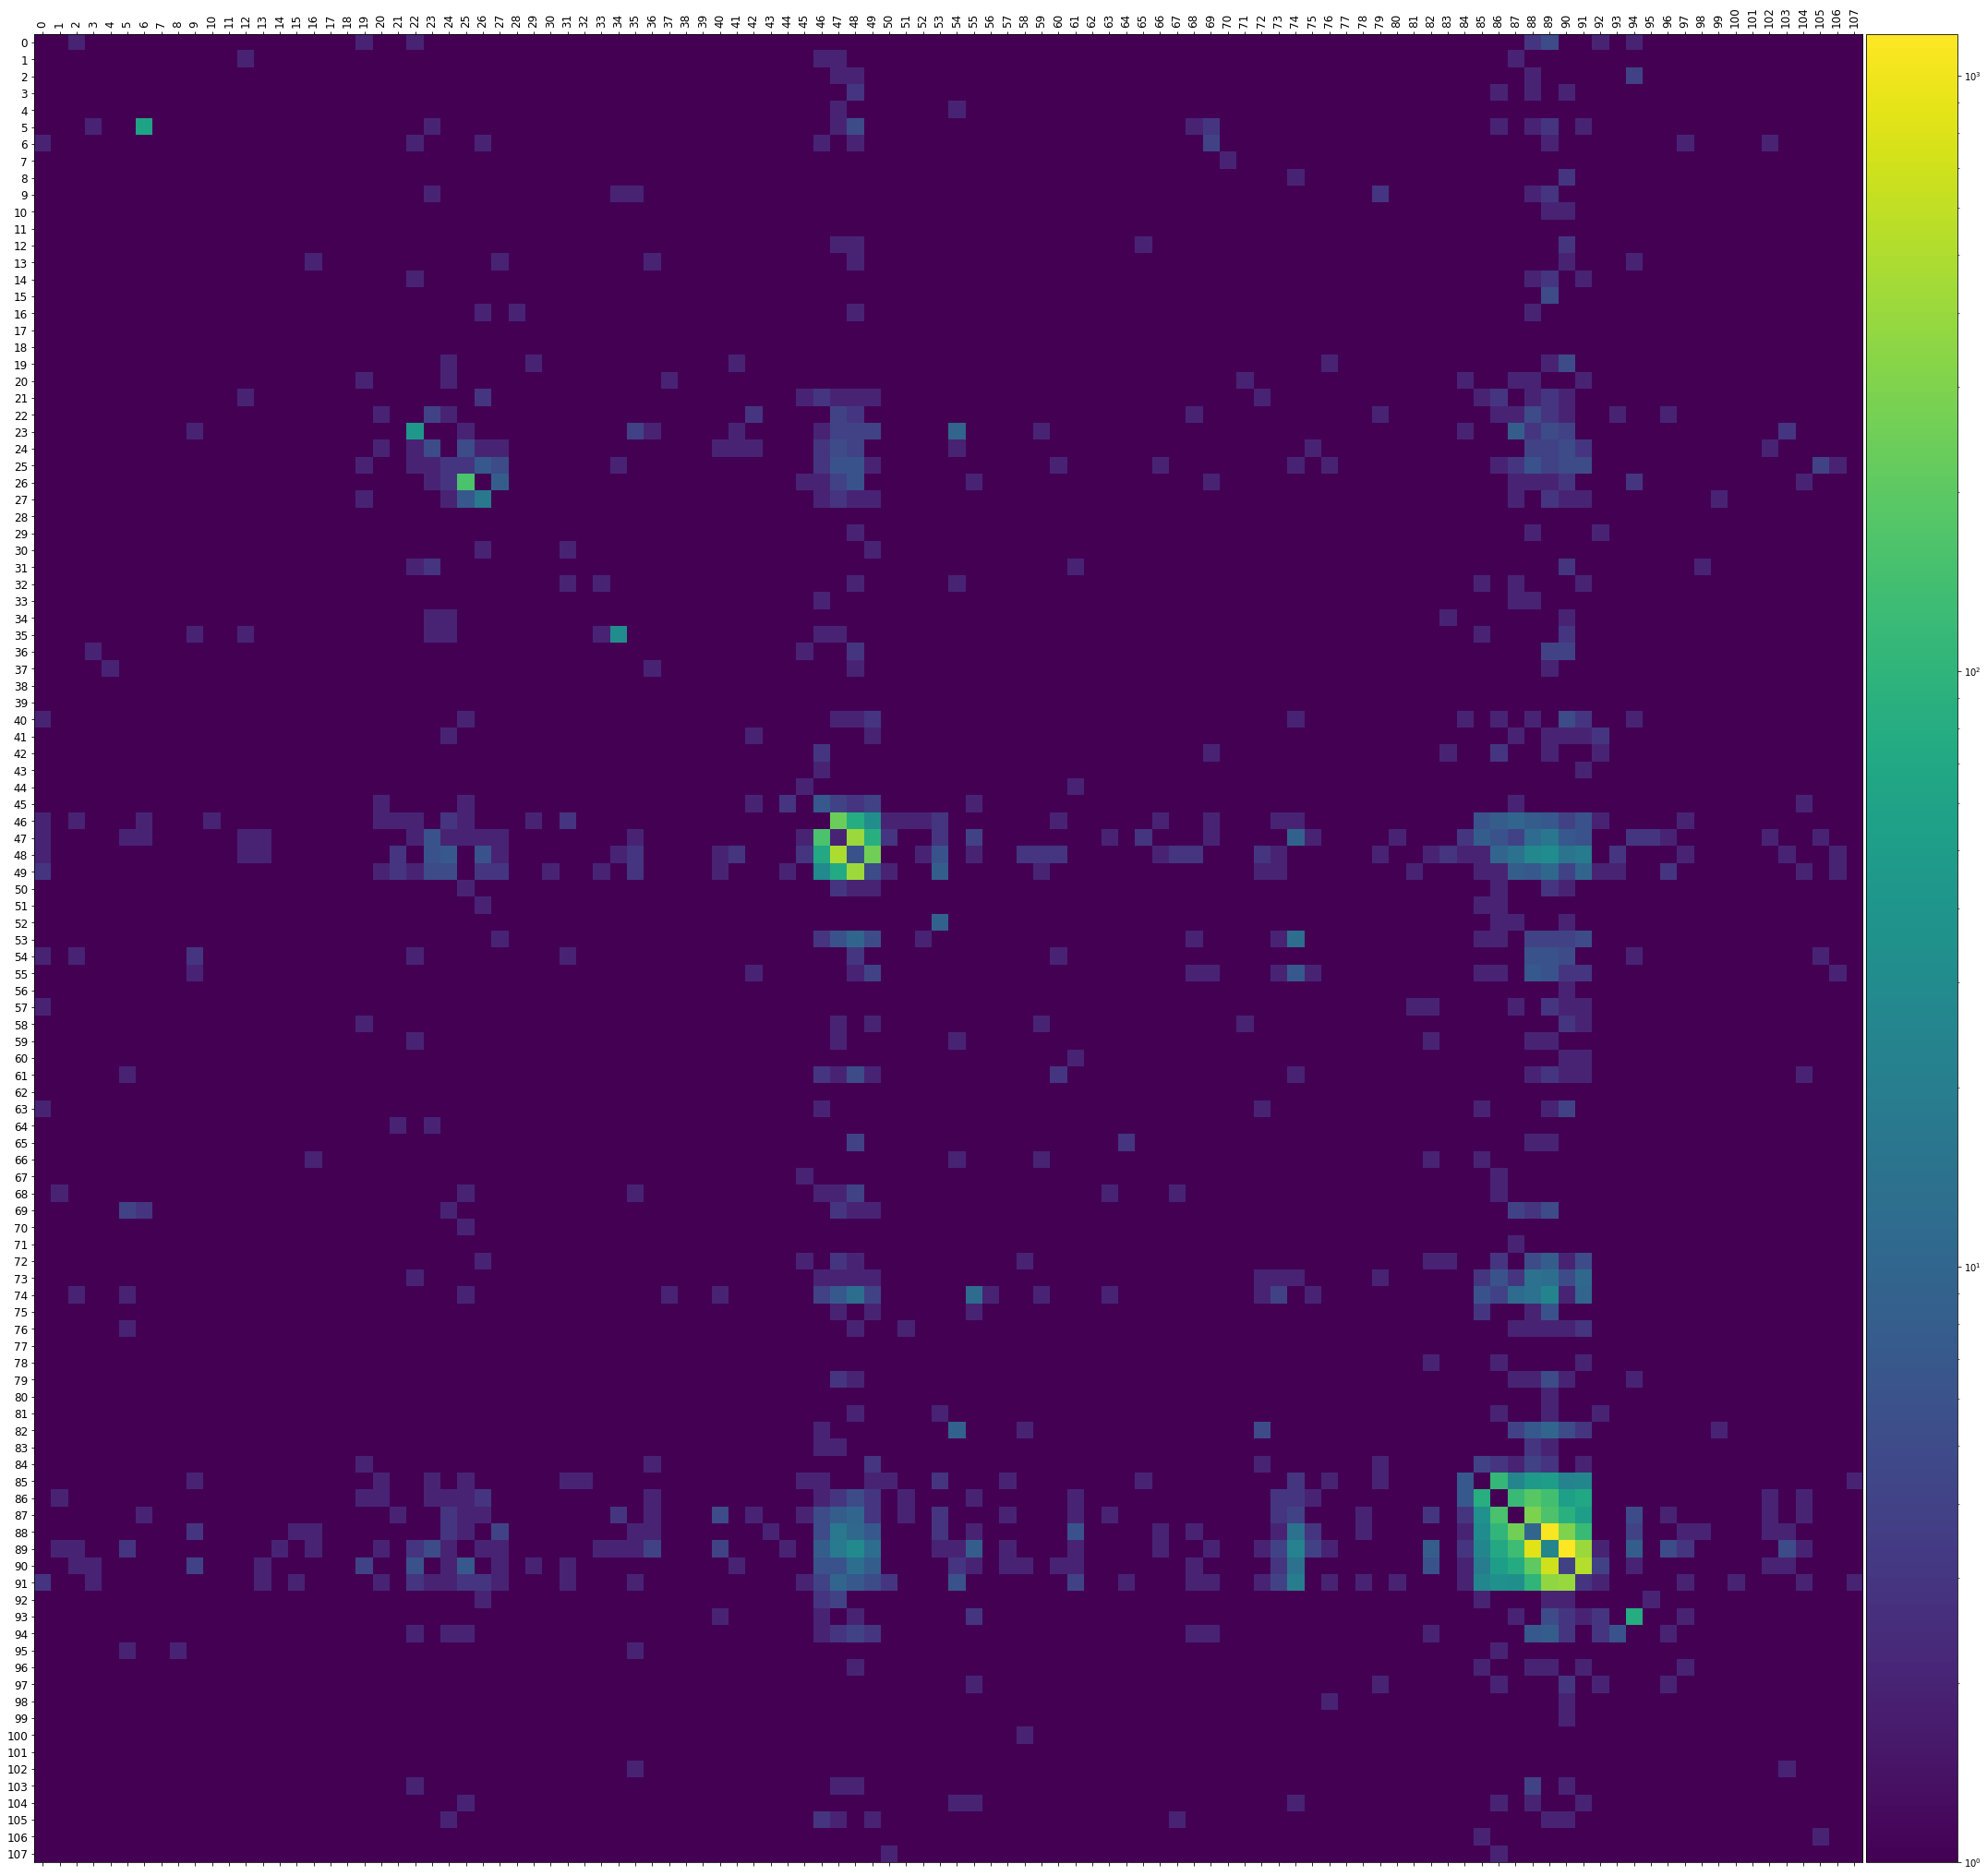

In [144]:
longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
sequence_transitions = matshow_cluster(range(108), longer, reduced_dataset.labels_, 0)
sequence_transitions.tight_layout()
sequence_transitions.savefig('cluster_0_BeSa.pdf')

In [ ]:
def cluster(eps=0.4, ied_step_size=1):
    longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
    
    clustering = DBSCAN(eps=eps, min_samples=500, metric='precomputed').\
    fit(distance_matrix)
    assigned_clusters = clustering.labels_
    
    cluster_counts = np.unique(assigned_clusters, return_counts=True)[1]

    print(cluster_counts)

    for cluster in range(-1, len(cluster_counts) - 1):
        matshow_cluster(range(108), longer, assigned_clusters, cluster)
        
    return assigned_clusters
    
cluster()

In [ ]:
longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]

In [ ]:
y_clusters = []

for cluster in range(-1, 2):
    y_cluster = [0] * features.shape[0]
    for label, spike in zip(assigned_clusters, longer):
        if cluster == label:
            y_cluster[int(spike[0] // 2048)] += 1
    y_cluster = np.array(y_cluster)
    y_clusters.append(y_cluster)

In [ ]:
y_clusters

In [ ]:
N = 2000
cumsum, moving_aves = [0], []

for i, x in enumerate(y_clusters[0], 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)

plt.plot(np.array(moving_aves) / np.array(moving_aves).max(), label='No cluster')

cumsum, moving_aves = [0], []

for i, x in enumerate(y_clusters[1], 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)
    
plt.plot(np.array(moving_aves) / np.array(moving_aves).max(), label='Cluster 1')

cumsum, moving_aves = [0], []

for i, x in enumerate(y_clusters[2], 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)
    
plt.plot(np.array(moving_aves) / np.array(moving_aves).max(), label='Cluster 2')
plt.legend()

In [20]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
from pandas.plotting import register_matplotlib_converters

/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


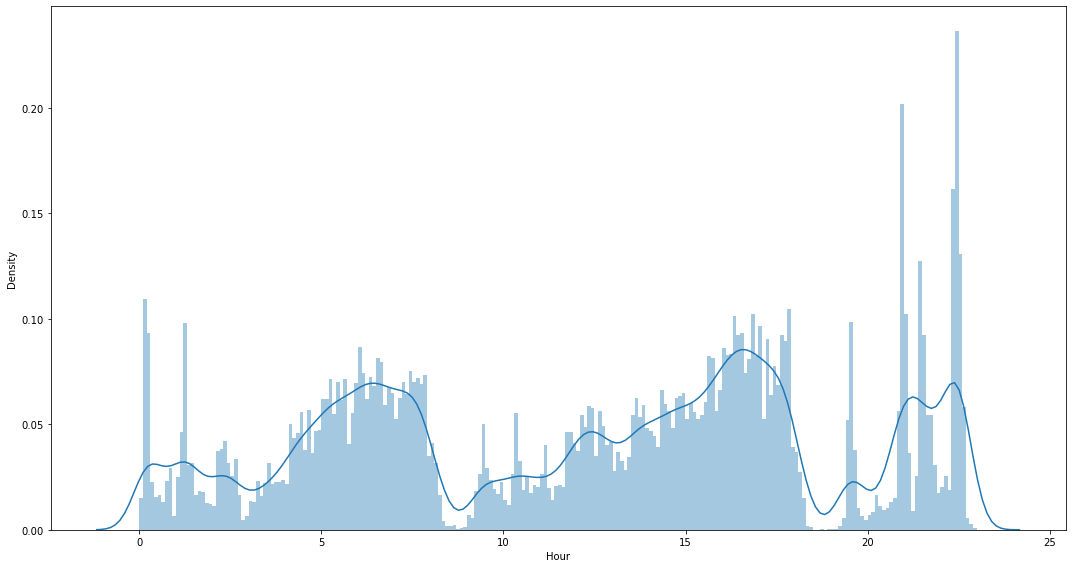

In [185]:
matplotlib.rcParams['figure.figsize'] = (15, 8)

sequence_starts = [spike[0] / (2048 * 60**2) for spike in all_seq_spikes]
ax = sns.distplot(sequence_starts, bins=230, kde_kws={"bw_method": 0.06})

ax.set(xlabel='Hour')

plt.tight_layout()
plt.savefig('ied_timeplot_BeSa.pdf')

In [39]:
second

16559

In [278]:
window_length = 60

X = features.copy()

y = []

for second in range(int(len(X) / window_length)):
    y.append(len(spike_ids[np.logical_and(spike_ids > second * 2048 * window_length, \
                                          spike_ids < (second + 1) * 2048 * window_length)]))
    
y = np.array(y)

In [221]:
moving_aves = moving_aves[:13000]

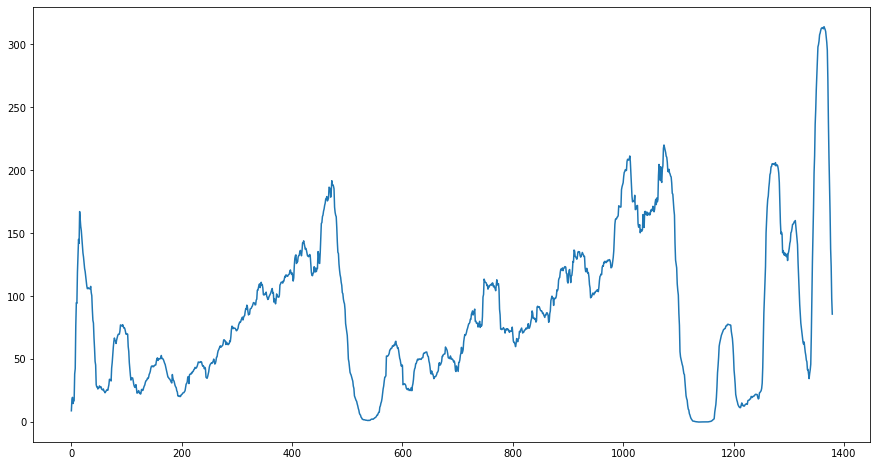

In [292]:
N = 30
cumsum, moving_aves = [0], []

for i, x in enumerate(y, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)

plt.plot(moving_aves)

Extracting phase between 214 and 426 days


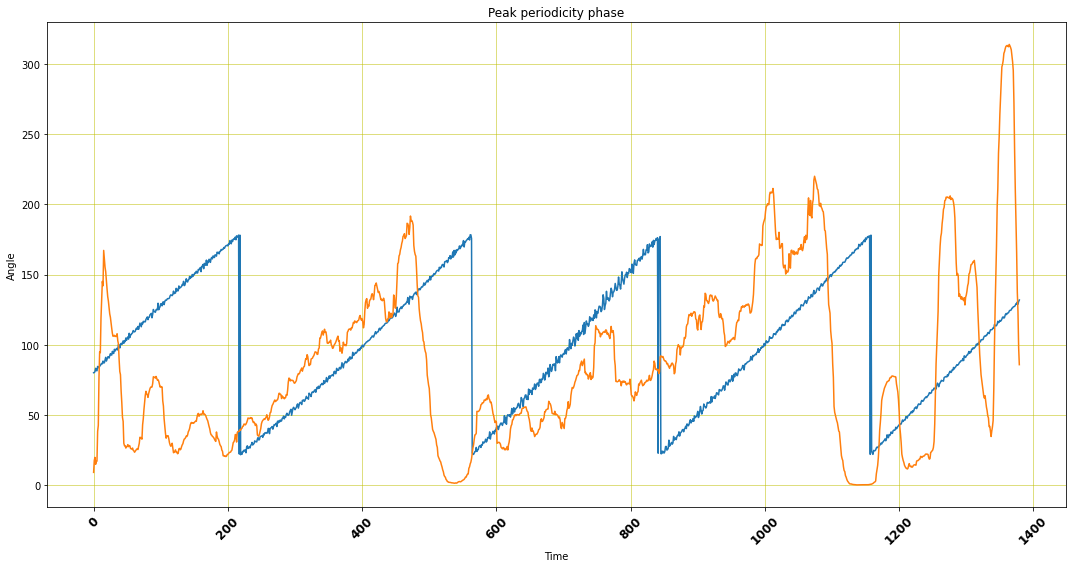

In [293]:
# take the peak of the periodogram
max_Pk = peaks[np.argmax(hights)]
max_Pk_inf = (round(Peak_period-.33*Peak_period))
max_Pk_sup = (round(Peak_period+.33*Peak_period))

idx_min = (np.abs(Periods - max_Pk_inf)).argmin()
idx_max = (np.abs(Periods - max_Pk_sup)).argmin()

print('Extracting phase between %0.0f and %0.0f days' %(max_Pk_inf,max_Pk_sup))


angle_peak_IEA=np.angle(coefficients_IEA[idx_min:idx_max,:].mean(axis=0))
#angle_peak_IEA=np.angle(coefficients_IEA[max_Pk,:])

plt.figure()
plt.title('Peak periodicity phase')
plt.plot(range(len(moving_aves)),100 + angle_peak_IEA * 25)
# plt.plot(TimeDate.iloc[PosSeizJE],angle_peak_IEA[PosSeizJE],'r*')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.tight_layout()
plt.plot(moving_aves)
plt.show()
 

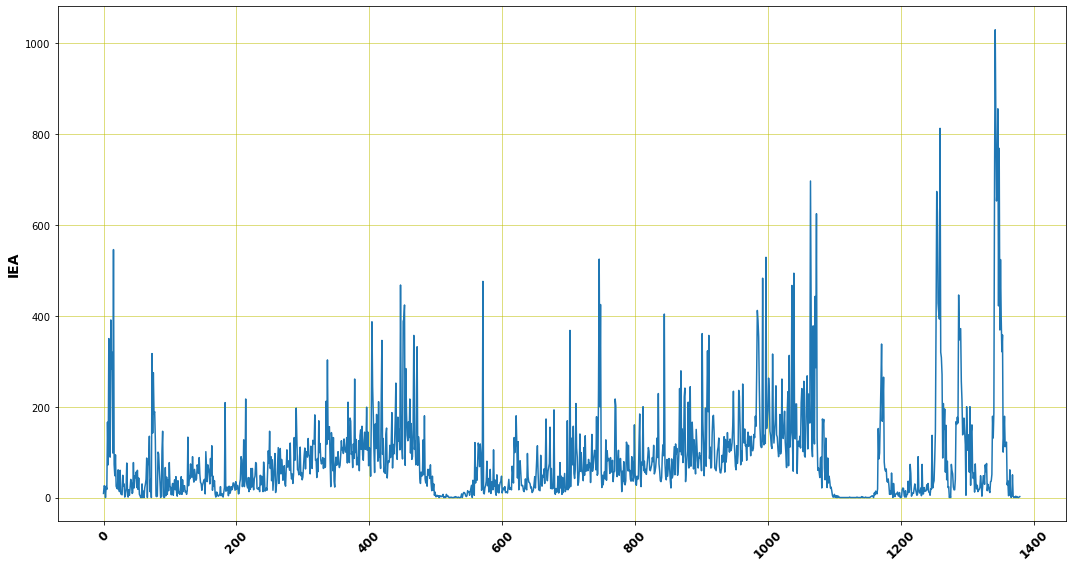

In [280]:
plt.figure()
plt.plot(range(len(moving_aves)), moving_aves[:])
plt.ylabel('IEA', weight='bold', fontsize=14)
#plt.xlim((4900, 51divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)00))
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.tight_layout()
plt.show()

In [295]:
# fs = 1
scales = np.arange(200, 700, 5)
frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / 1
print(1/frequencies)

[200. 205. 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265.
 270. 275. 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335.
 340. 345. 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405.
 410. 415. 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475.
 480. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 570. 575. 580. 585. 590. 595. 600. 605. 610. 615.
 620. 625. 630. 635. 640. 645. 650. 655. 660. 665. 670. 675. 680. 685.
 690. 695.]


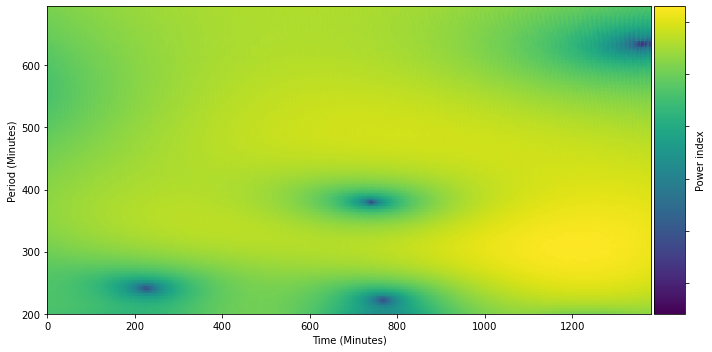

In [321]:
matplotlib.rcParams['figure.figsize'] = (10, 5)


[coefficients_IEA, frequencies] = pywt.cwt(moving_aves, scales,'cmor1.5-1.0',1)
power_IEA = np.log((abs(coefficients_IEA)))
Periods = 1/frequencies

fig = plt.figure()
ax = fig.add_subplot(111)

# plt.figure(figsize=(8, 4))
c=ax.pcolormesh(range(len(moving_aves)),Periods,power_IEA,cmap='viridis', shading='gouraud',vmin = .6*power_IEA.min(), vmax = power_IEA.max())
# plt.title('Wavelet transform power')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(c, cax=cax)

# cbar = plt.colorbar(c)
cbar.set_label('Power index')
cbar.ax.set_yticklabels([])
ax.set_ylabel('Period (Minutes)')
ax.set_xlabel('Time (Minutes)')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.tight_layout()
plt.savefig('wavelet_transform_BeSa.pdf')
plt.show()

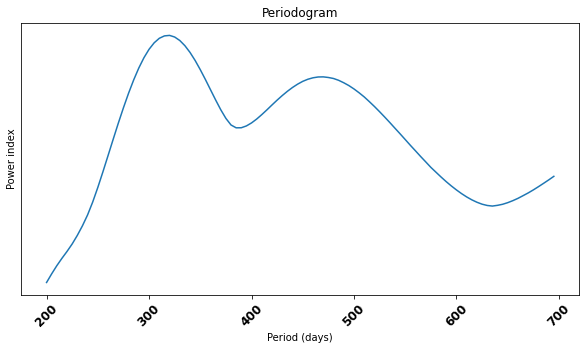

In [323]:
# Periodogram
power_IEA = (abs(coefficients_IEA))
Av_power = np.mean(power_IEA, axis=1)

plt.figure()
plt.title('Periodogram')
plt.plot(Periods, Av_power)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.xlabel('Period (days)')
plt.ylabel('Power index')
plt.yticks([])
plt.savefig('periodogram_BeSa.pdf')
plt.show() 

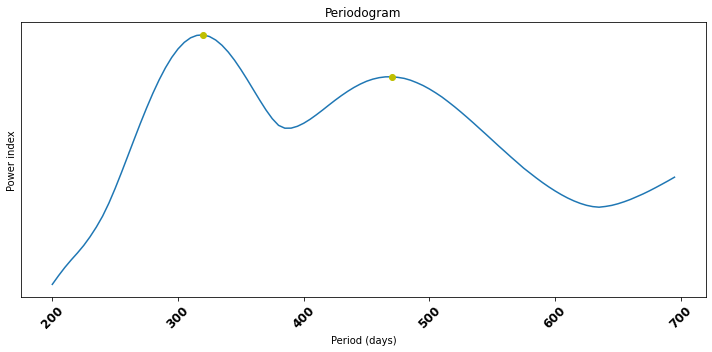

Peak of the periodogram = 320


In [324]:
# peak frequency 
sm_Av_power = signal.savgol_filter(Av_power, 11, 7)  
# we smooth the periodogram to find its peak with a window size of 11 and a  polynomial fit of order 7
peaks, properties = signal.find_peaks(sm_Av_power,np.mean(sm_Av_power)) #We find the few peaks of the periodogram
hights = properties['peak_heights']
Peak_period = (Periods[peaks[np.argmax(hights)]])  # We take the peak-periodicity with the highest power
plt.figure()
plt.title('Periodogram')
plt.plot(Periods, Av_power)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.xlabel('Period (days)')
plt.ylabel('Power index')
plt.yticks([])
#plt.plot(Periods[peaks[0:3]],Av_power[peaks[0:3]],'yo')
plt.plot(Periods[peaks], Av_power[peaks],'yo')

# plt.plot(Periods[peaks[1]], Av_power[peaks[1]],'ro')
plt.tight_layout()
plt.show()
print('Peak of the periodogram = %0.0f' %Peak_period)
